In [ ]:
# 실습3 : movilenetv2 전이학습하여 개,고양이 분류 모델 생성

import tensorflow_datasets as tfds
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
train 원본(전체)갯수 : 23262
raw train 갯수 : 18609
원본 1장 : :  (262, 350, 3) 1
dog


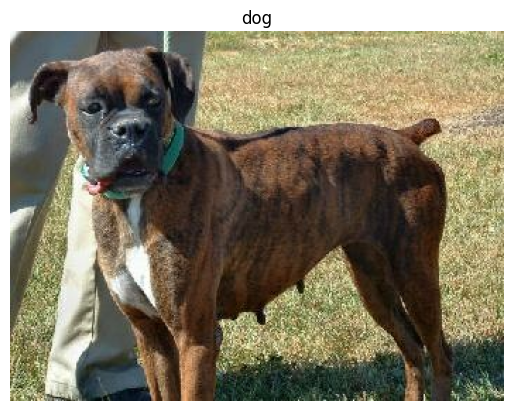

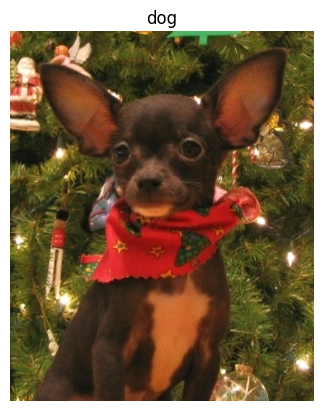

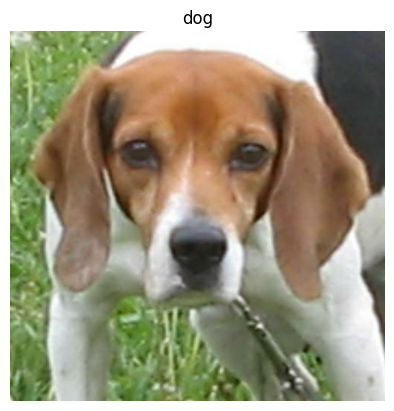

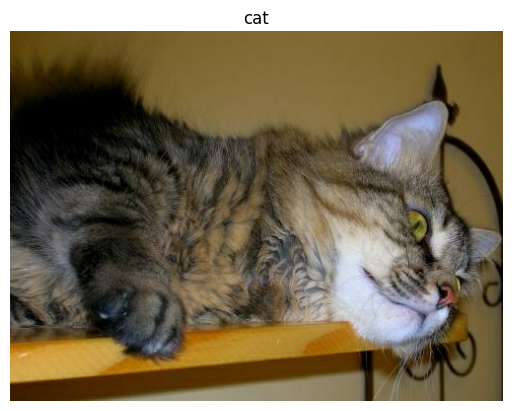

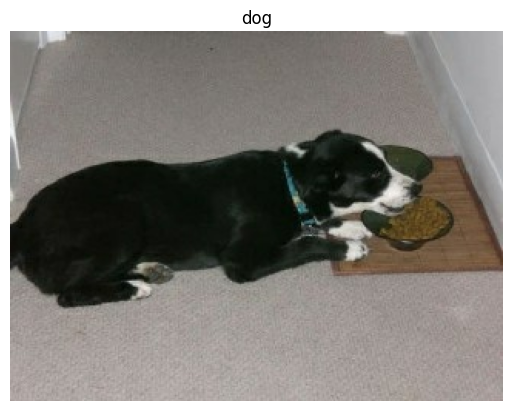

In [ ]:
# tfds의 로딩 진행바를 비활성화하여 화면을 깔끔하게 만듦.
tfds.disable_progress_bar()

# 'cats_vs_dogs' 데이터셋을 로드하고, 학습/검증/테스트용으로 나뉨.
# split: 데이터셋을 80%, 10%, 10% 비율로 분할
# with_info=True: 데이터셋에 대한 메타데이터(정보)를 가져 옴.
# as_supervised=True: 데이터를 (이미지, 레이블) 튜플 형태로 반환.
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,     # 관련 정보 얻기
    as_supervised=True, # 반환 type 튜플 , False : dict
)

print(raw_train)
print(raw_validation)
print(raw_test)
# print(metadata)   # 메타데이터는 데이터셋의 구조, 레이블 이름 등을 포함
total = metadata.splits['train'].num_examples
print('train 원본(전체)갯수 :' ,total)
print('raw train 갯수 :' ,int(total*0.8))

# 원본 데이터셋에서 샘플 1장을 가져와 크기와 레이블을 확인
# 샘플 크기
for image, label in raw_train.take(1):
    print("원본 1장 : : ", image.shape, label.numpy())

# 레이블(정수)을 'cat' 또는 'dog'와 같은 문자열로 변환하는 함수를 얻
# 레이블 확인
get_label_name=metadata.features['label'].int2str
print(get_label_name(1))

# 원본 이미지 5장을 시각화하여 데이터가 제대로 로드되었는지 확인
for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')
    plt.show()

In [ ]:
# 전처리
IMG_SIZE = 160
def format_ex(image, label):
   # 이미지를 uint8 타입(0~255)에서 float32 타입으로 변환
  image = tf.cast(image, tf.float32)    #uint8 -> float32
   # 픽셀 값을 -1.0 ~ 1.0 사이로 정규화
  image = (image/127.5) - 1.0
  # 모든 이미지를 동일한 크기(160x160)로 리사이즈(resize)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label  # 함수는 2개의 값을 반환한다. 튜플타입

# autotune : 텐서플로우가 GPU/CPU 갯수/리소스을 자동으로 최적화하여 데이터 로드 속도를 높임.
# GPU idle time을 최소화
# map() 함수를 통해 각 데이터셋의 모든 이미지에 format_ex 함수를 적용
train = raw_train.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)
validation = raw_validation.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)
test = raw_test.map(format_ex, num_parallel_calls=tf.data.AUTOTUNE)
for img, label in train.take(1):
  print('전처리 결과 type :' , img.dtype)
  print('전처리 결과 shape : ', img.shape)
  print('min/ max : ', float(tf.reduce_min(img)), float(tf.reduce_max(img)))

# 배치 파이프라인작성(학습용/검증용)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
#  1000의 샘플을 메모리에 가져와 무작위로 섞음 -> 그 다음 데이터 버퍼에 읽어 또 섞음
# batch(BATCH_SIZE): 32장씩 묶어 '배치'를 만듦.
# prefetch(): 모델이 훈련하는 동안 다음 배치를 미리 가져와 대기 시간을 줄.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for image_single, label_single in raw_train.take(1):
  print("원본 단일 이미지 shape: ", image_single.numpy().shape)
  print('레이블 : ' , label_single.numpy())

전처리 결과 type : <dtype: 'float32'>
전처리 결과 shape :  (160, 160, 3)
min/ max :  -1.0 1.0
원본 단일 이미지 shape:  (262, 350, 3)
레이블 :  1


In [27]:
# base model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# print(base_model.summary())

# 전처리/batch 된 텐서를 통과시켜 특징 맵 얻기
images_batch, labels_batch = next(iter(train_batches))
feature_batch = base_model(images_batch)
print('입력 배치 shape :', images_batch.shape)    # (32, 160, 1600, 3  )
print('특징맵 배치 shape :', feature_batch.shape) # (32, 5, 5, 1280) - 160x160 이미지가 5x5 크기로 줄어들고 1280개의 특징이 추출됨

# GlobalAveragePooling2D: 컨볼루션 출력의 모든 픽셀을 평균내어 하나의 벡터로 만듦.
global_avg = tf.keras.layers.GlobalAveragePooling2D()(feature_batch)

print('GAP 이후 shape :' , global_avg.shape)    # (32, 1280) - 이미지당 1280개의 특징이 됨


# model 정의
# Sequential api
# model = tf.keras.layers.Sequential([
#   tf.keras.layers.Input(shape=IMG_SHAPE),
##   base_model을 '특징 추출기'로 사용. training=False는 동결된 상태로 추론만 하겠다는 의미.
#   base_model, #특징 추출기 (컨볼루션) - 동결 상태
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# Functional api
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# 1개의 뉴런과 sigmoid 활성화 함수는 이진 분류(0 or 1)에 사용
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
base_model.trainable = False  # base_model의 가중치를 동결(freeze)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 전이 학습 단계: 새로운 분류 레이어만 학습
history = model.fit(train_batches,
                    epochs=5,
                    verbose=1,
                    validation_data=validation_batches)

test_loss, test_acc = model.evaluate(test_batches, verbose=0)
print(f'test loss : {test_loss:.4f}')
print(f'test accuracy : {test_acc:.4f}')

입력 배치 shape : (32, 160, 160, 3)
특징맵 배치 shape : (32, 5, 5, 1280)
GAP 이후 shape : (32, 1280)
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.9427 - loss: 0.1412 - val_accuracy: 0.9811 - val_loss: 0.0489
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - accuracy: 0.9843 - loss: 0.0446 - val_accuracy: 0.9819 - val_loss: 0.0443
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 0.9873 - loss: 0.0386 - val_accuracy: 0.9841 - val_loss: 0.0458
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9870 - loss: 0.0364 - val_accuracy: 0.9841 - val_loss: 0.0464
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.9885 - loss: 0.0331 - val_accuracy: 0.9841 - val_loss: 0.0431
test loss : 0.0468
test accuracy : 0.9807


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


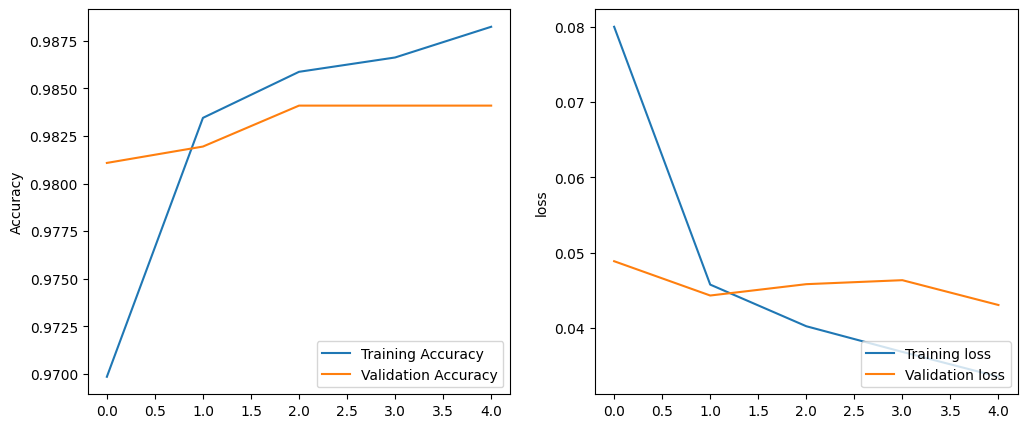

In [28]:
# history 확인
print(history.history.keys())
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.ylabel('loss')


plt.show()


In [30]:
# Fine-tune (미세 조정)
base_model.trainable = True # 백본의 특징 추출기 동결해제(unfreeze)
fine_tune_at = 100  # 백본의 100번째 레이어까지만 동결유지할 계획
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
# 모델을 다시 컴파일. 미세 조정을 위해 학습률(learning_rate)을 매우 작게 설정.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])
# 체크포인트, 학습률 감소, 조기 종료 콜백을 정의하여 효율적으로 학
chk_path_ft = 'finetune_best.keras'
callback_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        chk_path_ft, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(   #val_loss개선이 멈추면 lr을 0.5배 줄임
        monitor='val_loss', factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
]

EPOCHS_TRANSFER = 5
EPOCHS_FINETUNE = 5

# 전이학습이 끝난 후 이어서 학습 시작
history_ft = model.fit(train_batches,
                    validation_data=validation_batches,
                    epochs=EPOCHS_TRANSFER + EPOCHS_FINETUNE,
                    initial_epoch=len(history.history['loss']),
                    callbacks=callback_ft,
                    verbose=2
)


test_loss, test_acc = model.evaluate(test_batches, verbose=0)
print(f'fine tune => test loss : {test_loss:.4f}')
print(f'fine tune => test accuracy : {test_acc:.4f}')

Epoch 6/10

Epoch 6: val_accuracy improved from -inf to 0.98495, saving model to finetune_best.keras
582/582 - 92s - 157ms/step - accuracy: 0.9666 - loss: 0.0895 - val_accuracy: 0.9850 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.98495
582/582 - 39s - 67ms/step - accuracy: 0.9900 - loss: 0.0286 - val_accuracy: 0.9759 - val_loss: 0.1030 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.98495

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
582/582 - 42s - 72ms/step - accuracy: 0.9958 - loss: 0.0132 - val_accuracy: 0.9746 - val_loss: 0.1077 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_accuracy did not improve from 0.98495
582/582 - 81s - 140ms/step - accuracy: 0.9974 - loss: 0.0075 - val_accuracy: 0.9798 - val_loss: 0.0750 - learning_rate: 5.0000e-05
Epoch 10/10

Epoch 10: val_accuracy did not improve from 0.98495

Epoch 10: ReduceLROnPlateau reducing learning

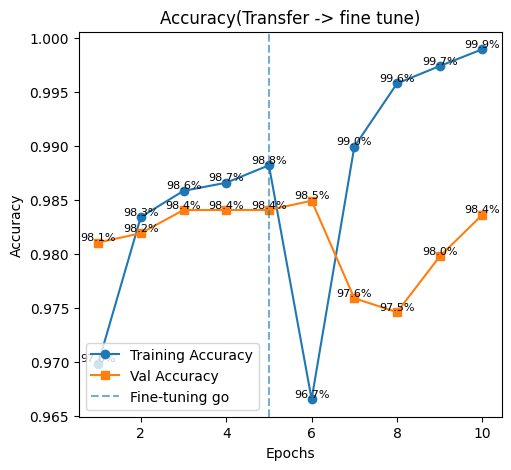

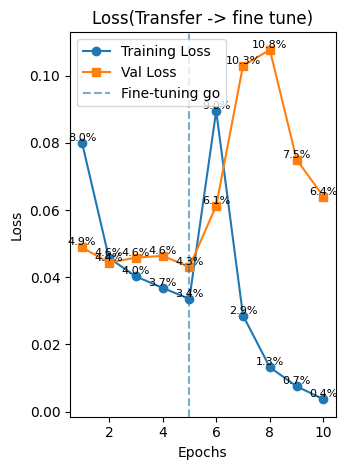

In [38]:
# 전이학습 vs 미세조정 학습 곡선 결합한 시각화

def concat_hist_func(h1, h2):
  keys = h1.history.keys()
  out = {}
  for k in keys:
    out[k] = h1.history[k] + h2.history[k]
  return out


hist_all = concat_hist_func(history, history_ft)
acc = hist_all['accuracy']
val_acc=hist_all['val_accuracy']
loss = hist_all['loss']
val_loss = hist_all['val_loss']

epochs = range(1, len(acc) + 1)
split_epoch = EPOCHS_TRANSFER # 전이학습과 미세조정 경계선 위치

plt.figure(figsize=(12, 5))
# 정확도 --
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Val Accuracy')
for i, v in enumerate(acc):
  plt.text(epochs[i], v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(val_acc):
  plt.text(epochs[i], v, f'{v*100:.1f}%' ,ha='center', va='bottom', fontsize=8)

plt.axvline(split_epoch, linestyle='--', alpha=0.6, label='Fine-tuning go')
plt.title('Accuracy(Transfer -> fine tune)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.show()
# 손실 --
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', label='Val Loss')
for i, v in enumerate(loss):
  plt.text(epochs[i], v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(val_loss):
  plt.text(epochs[i], v, f'{v*100:.1f}%' ,ha='center', va='bottom', fontsize=8)

plt.axvline(split_epoch, linestyle='--', alpha=0.6, label='Fine-tuning go')
plt.title('Loss(Transfer -> fine tune)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1. tf.data.Dataset의 중요성
메모리 효율성: tf.data는 모든 데이터를 한 번에 메모리에 로드하지 않고, 필요할 때마다 조금씩 읽어오는 스트리밍(streaming) 방식.
덕분에 수백 GB에 달하는 대용량 데이터도 효율적으로 처리할 수 있다.

성능 최적화: map(), shuffle(), batch(), prefetch() 등의 메서드는 데이터 파이프라인을 최적화하여 GPU가 데이터를 기다리는 시간을 최소화.
특히 prefetch(tf.data.AUTOTUNE)는 데이터 로딩과 모델 훈련을 병렬로 진행시켜 학습 속도를 크게 높여줌.

2. GlobalAveragePooling2D vs. Flatten
Flatten: 컨볼루션 레이어의 출력을 단순히 1차원 벡터로 펼침. 이미지의 공간적 정보가 유지되지만, 그만큼 최종 Dense 레이어의 파라미터(가중치)가 기하급수적으로 늘어나 모델이 무거워지고 과적합의 위험이 커짐.

GlobalAveragePooling2D: 특징 맵의 모든 값을 평균내어 하나의 값으로 만듦. 이는 파라미터 수를 획기적으로 줄여주기 때문에 과적합을 방지하고 모델을 가볍게 만듦. 전이 학습 시, 이미 MobileNetV2가 추출한 특징들은 충분히 중요하므로 이 방식을 사용하는 것이 일반적.

3. 콜백(Callbacks)
코드는 ModelCheckpoint, ReduceLROnPlateau, EarlyStopping이라는 세 가지 중요한 콜백을 사용.

ModelCheckpoint: 훈련 중 성능이 가장 좋았던 모델의 가중치를 자동으로 저장.

ReduceLROnPlateau: 모델의 성능(손실)이 더 이상 개선되지 않으면, 학습률을 자동으로 낮춰줌. 이는 훈련이 정체될 때 더 세밀하게 가중치를 조정하여 최적의 지점을 찾게 도움.

EarlyStopping: 모델의 성능이 일정 기간 동안 개선되지 않으면, 훈련을 조기에 중단하여 불필요한 계산을 막아줌.

이러한 콜백들은 수동으로 학습 과정을 지켜볼 필요 없이 모델을 효율적으로 훈련시키는 데 필수적인 도구.

4. 시각화의 중요성
학습 곡선 분석: 훈련 정확도(Training Accuracy)와 검증 정확도(Validation Accuracy)를 비교하여 **과적합(overfitting)**이 일어났는지 확인할 수 있다.

전이 학습 vs. 미세 조정: 그래프에 Fine-tuning go 표시를 함으로써, 미세 조정을 시작한 이후 모델의 성능이 어떻게 변화하는지 한눈에 파악할 수 있다. 일반적으로 미세 조정 후에는 정확도가 미세하게 상승하고 손실이 줄어드는 경향을 보임.